In [35]:
import pandas as pd
import numpy as np

# pd.set_option('display.max_columns', None,'display.max_rows',None)
np.random.seed(73)

# Algorithms

# Logistic Regression

In [36]:
class LogisticRegression:
    def __init__(self,params):
        self.W=np.ones(params['n'])
        self.b=params['b']
        self.alpha=params['alpha']
        self.epoch=params['epoch']
        self.lemda=params['lemda']
        self.regularization=False
    
    def linearFunction(self,X):
        h= np.dot(self.W,X.T)+self.b
        return h
    def sigmoidFunction(self ,h):
        y_pred=1/(1+np.exp(-h))
        return y_pred
    
    def gradientDescent(self,X,Y,y_pred):
        dw=np.dot((Y-y_pred),X)
        dw/=len(X)
        db= np.mean(Y-y_pred)
        return dw,db
    
    def updateParam(self,dw,db):
        temp=self.W
        self.W+=self.alpha*dw 
        if(self.regularization == True):
            self.W-= self.alpha*self.lemda*np.sign(temp)
        self.b+=self.alpha*db
    def fit(self,X,Y):
        for i in range (self.epoch):
            h=self.linearFunction(X)
            y_pred=self.sigmoidFunction(h)
            dw,db=self.gradientDescent(X,Y,y_pred)
            self.updateParam(dw,db)
    def predict(self,X):
        z=self.linearFunction(X)
        h=self.sigmoidFunction(z)
        y_pred=np.array(h>=0.5,dtype=int)
        return y_pred
    def y_prob(self,X):
        z=self.linearFunction(X)
        h=self.sigmoidFunction(z)
        return h
    def changeRegularization(self,value):
        self.regularization=value


# Bagging

In [37]:
class Bagging:
    
    def __init__(self):
        
        self.NoTrainingSet=9
        self.Models=[]

    def Bagging_sampling(self,X,Y):
        n=len(X)
        index=np.random.choice(n,size=n,replace=True)
        X_sample=X[index]
        Y_sample=Y[index]
        return X_sample,Y_sample
    
    def fit(self,X,Y):
        params={
                'n':X.shape[1],
                'b':1,
                'alpha':0.009,
                'epoch':10000,
                'lemda':0.001
            }
        for i in range (self.NoTrainingSet):
            X_sample,Y_sample=self.Bagging_sampling(X,Y)
            model=LogisticRegression(params)
            model.fit(X_sample,Y_sample)
            self.Models.append(model)
    
    def predict(self,X):

        y_predict=np.zeros(len(X))
        for i in range (len(self.Models)):
           y_predict+=(self.Models[i]).predict(X)
        
        y_predict/=self.NoTrainingSet
        y_predict=np.array(y_predict>=0.5,dtype=int)
        return y_predict
    
    def y_prob(self,X):
        y_probability=np.zeros(len(X))
        for i in range (len(self.Models)):
           y_probability+=(self.Models[i]).y_prob(X)
        
        y_probability/=self.NoTrainingSet
        return y_probability

# Stacking

In [38]:
class stacking:

   def __init__(self):
    #   self.params=params
      self.Basemodels=[]
      self.predictedFeatures=[]
      self.metaModel=None
    
   def fitBaseModel(self,X_train,Y_train):
      bag=Bagging()
      bag.fit(X_train,Y_train)
      self.Basemodels=bag.Models
   def fitMetaModel(self,X_validation,Y_validation):
      for model in (self.Basemodels):
        self.predictedFeatures.append(model.predict(X_validation))
      
      for y_pred in (self.predictedFeatures):
        np.insert(X_validation,X_validation.shape[1],y_pred,axis=1)
      
      params={
                'n':X_validation.shape[1],
                'b':1,
                'alpha':0.009,
                'epoch':10000,
                'lemda':0.001
            }
      
      metaModel=LogisticRegression(params)
      metaModel.fit(X_validation,Y_validation)
      return metaModel
      
   def fit(self,X_train,Y_train,X_validation,Y_validation):
      self.fitBaseModel(X_train,Y_train)
      self.metaModel=self.fitMetaModel(X_validation,Y_validation)

   def predict(self,X_test):
      y_features=[]
      for model in (self.Basemodels):
        y_features.append(model.predict(X_test))
      
      for y_pred in (y_features):
        np.insert(X_test,X_test.shape[1],y_pred,axis=1)
      y_predicted=self.metaModel.predict(X_test)
      return y_predicted
   def y_prob(self,X_test):
      y_features=[]
      for model in (self.Basemodels):
        y_features.append(model.predict(X_test))
      
      for y_pred in (y_features):
        np.insert(X_test,X_test.shape[1],y_pred,axis=1)
      y_prob=self.metaModel.y_prob(X_test)
      return y_prob


# Performance Metric

In [39]:
class metric:
    def __init__(self) -> None:
        self.TP=0
        self.TN=0
        self.FP=0
        self.FN=0
    def count(self,Y_actual,Y_pred):
        self.TP=np.sum((Y_actual==1) & (Y_pred==1)) #true positive
        self.TN=np.sum((Y_actual==0) & (Y_pred==0)) #true negative
        self.FP=np.sum((Y_actual==0) & (Y_pred==1)) #False positive
        self.FN= np.sum((Y_actual==1) & (Y_pred==0)) #False negative

    def accuracy(self):
        
        total=self.TP+self.TN+self.FP+self.FN
        accuracy=(self.TP+self.TN)/total
        return accuracy
    
    def sensitivity(self):
        sensitivity=self.TP/(self.TP+ self.FN)
        return sensitivity
    
    def specificity(self):
        specificity= self.TN /(self.TN+ self.FP)
        return specificity
    
    def precesion(self):
        precesion =self.TP /(self.TP + self.FP)
        return precesion
    def F1Score(self):
        F1Score= (2*self.precesion()*self.sensitivity())/(self.precesion()+self.sensitivity())
        return F1Score
    

# understanding the dataset

In [40]:
def loadDataSet(path):
   dataFrame=pd.read_csv(path)
   return dataFrame


# Data Cleaning

In [41]:
def DataCleaning(dataFrame,target):

    ## replacing data with the column wise mean
    dataFrame.fillna(dataFrame.mean(numeric_only=True),inplace=True)

    #replacing non numeric data with mode 
    objectColumns= dataFrame.select_dtypes(include='object').columns
    for col in objectColumns:
        dataFrame[col]= dataFrame[col].fillna(dataFrame[col].mode()[0])
    
    ## For any duplicates in the dataset, keep just one copy of the data
    dataFrame.drop_duplicates(inplace=True)  
    
    ## drop the row for null value in target column
    dataFrame.dropna(subset=[target],inplace=True)
    return dataFrame


# Data Encoding

In [42]:
from sklearn.preprocessing import LabelEncoder
def dataEncoding(Features,Target):

    ## label encoding of target
    Target=LabelEncoder().fit_transform(Target)
 
    ## one hot encoding of features
    for feature in Features.columns:
        if Features[feature].dtype == 'object':
                Features[feature]= Features[feature].astype('category')
    
    Features=pd.get_dummies(Features)
    return Features,Target

# Scaling of Features

In [43]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def Scale(type,Features):
    
    if type == 'standard':
            scalar= StandardScaler()
    elif type=='minmax':
            scalar= MinMaxScaler()
    
    boolean_columns = Features.select_dtypes(include=['bool']).columns
    columns_to_scale = Features.columns.difference(boolean_columns)
    Features[columns_to_scale]= scalar.fit_transform(Features[columns_to_scale])
    return Features

# Correlation Analysis 

In [44]:
def correlationAnalysis(Features,Target,TargetName,noOfFeatures):
    correlationWithTarget=Features.corrwith(Target[TargetName])
    sortedCorrelationWithTarget=correlationWithTarget.abs().sort_values(ascending=False)
    TopFeatures_index= sortedCorrelationWithTarget[:noOfFeatures].index
    TopFeatures=Features[TopFeatures_index]
    return TopFeatures

## General Analysis of data

In [45]:
# testData=loadDataSet("creditcard.csv")
# testData

In [46]:
# testData.shape

In [47]:
# testData.describe()

## preprocess of Telco-Customer-Churn dataset

In [48]:
def preprocessOfTelcoCustomerChurn():
    dataFrame=loadDataSet("WA_Fn-UseC_-Telco-Customer-Churn.csv")
    ## seeing the data types of columns
    print("data types of the dataFrame:\n")
    print(dataFrame.dtypes)
    ## Count the number of missing values in the dataset
    
    missingValue=dataFrame.isnull().sum()
    print("missingValue Before changing to numeric type\n:")
    print(missingValue)
    ###  Total charges should be float
    dataFrame['TotalCharges']=pd.to_numeric(dataFrame['TotalCharges'],errors='coerce')
    missingValue=dataFrame.isnull().sum()

    print("missing Value After changing to numeric type\n:")
    print(missingValue)
    ## Count the number of duplicate values in the dataset.
    
    print("\nNumber of duplicates without removing customerId:")
    dupCount=dataFrame.duplicated().sum()
    print(dupCount)
    
    ## removing customerId
    dataFrame = dataFrame.drop('customerID',axis=1)
    print("\nNumber of duplicates After removing customerId:")
    dupCount=dataFrame.duplicated().sum()
    print(dupCount)
    

    ############### Data cleaning ##############
    dataFrame=DataCleaning(dataFrame,"Churn")


    ############### Spliting Features and targets ###################
    Features = dataFrame.drop('Churn',axis=1)
    Target=dataFrame['Churn']
    
    ###############  Data Encoding ########################

    Features,Target=dataEncoding(Features,Target)

    ############## Feature scaling ##########################
    
    Features=Scale('minmax',Features)
    Target=pd.DataFrame(Target, columns=['Churn'])
    
    Features=Features.reset_index(drop=True)
    Target=Target.reset_index(drop=True)
    return Features,Target


# Features,Target=preprocessOfTelcoCustomerChurn()

# preprocess of adult dataset

In [49]:

def preprocessOfAdultDataset():
    columns=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','Class']
    train_set=pd.read_csv("adult.data",names=columns)
    test_set=pd.read_csv("adult.test",names=columns)
    dataFrame=pd.concat([train_set,test_set],ignore_index=True)

    ########## replacing ? with nan value ###########
    dataFrame.replace(' ?',np.nan,inplace=True)
    
    ########## replacing >50k. to >50k etc ################
    
    dataFrame.replace(' >50K.',' >50K',inplace=True)
    dataFrame.replace(' <=50K.',' <=50K',inplace=True)

    ############### Data cleaning ##############
    dataFrame=DataCleaning(dataFrame,"Class")


    ############### Spliting Features and targets ###################
    Features = dataFrame.drop('Class',axis=1)
    Target=dataFrame[['Class']]
    
    y_train=Target[Target.index <= 32560]
    y_test=Target[Target.index > 32560]

    y_train=y_train['Class']
    y_test=y_test['Class']

    
    ###############  Data Encoding ########################

    Features,y_train=dataEncoding(Features,y_train)
    y_test=LabelEncoder().fit_transform(y_test)
    

    ############## Feature scaling ##########################
    
    Features=Scale('standard',Features)


    y_train=pd.DataFrame(y_train, columns=['Class'])
    y_test=pd.DataFrame(y_test,columns=['Class'])
    Features=correlationAnalysis(Features,pd.concat([y_train,y_test]),"Class",50)
    y_train=y_train.reset_index(drop=True)
    y_test=y_test.reset_index(drop=True)
    
    return Features,y_train,y_test
# Features,y_train,y_test=preprocessOfAdultDataset()
# print(Features)
# print(y_train.shape)
# print(y_test.shape)


# preprocess of Creditcard dataset

In [50]:
def preprocessOfCreditCardDataset():
    dataFrame=loadDataSet("creditcard.csv")
    


    ############### Data cleaning ##############
    dataFrame=DataCleaning(dataFrame,"Class")


    dataframe_negatives=dataFrame[dataFrame['Class']==0]
    dataframe_negatives=dataframe_negatives.sample(n=20000,random_state=73)
    dataframe_positives=dataFrame[dataFrame['Class']==1]
    dataFrame= pd.concat([dataframe_negatives,dataframe_positives])

    # Shuffle the final DataFrame if needed
    dataFrame = dataFrame.sample(frac=1, random_state=73).reset_index(drop=True)


    ############### Spliting Features and targets ###################
    Features = dataFrame.drop('Class',axis=1)
    Target=dataFrame['Class']
    
    ###############  Data Encoding ########################

    Features,Target=dataEncoding(Features,Target)

    ############## Feature scaling ##########################
    
    Features=Scale('standard',Features)
    Target=pd.DataFrame(Target, columns=['Class'])
    
    Features=Features.reset_index(drop=True)
    Target=Target.reset_index(drop=True)
    return Features,Target


Features,Target=preprocessOfCreditCardDataset()

# Validating Pipeline

Performance on Test set:

Logistic Regression:
accuracy: 0.995116 sensitivity: 0.804348 specificity: 0.999500 precision: 0.973684 F1score: 0.880952 Auroc: 0.964035 AUPR:0.888126

Voting ensemble:
accuracy: 0.994872 sensitivity: 0.793478 specificity: 0.999500 precision: 0.973333 F1score: 0.874251 Auroc: 0.963519 AUPR:0.886183

Stacking ensemble:
accuracy: 0.995360 sensitivity: 0.815217 specificity: 0.999500 precision: 0.974026 F1score: 0.887574 Auroc: 0.956419 AUPR:0.887476

 Average and Stdev for the 9 bagging LR learners:
      Accuracy  Sensitivity  Specificity  Precision  F1-score     AUROC  \
mean  0.994763     0.793478     0.999389   0.967785  0.871903  0.885959   
std   0.000248     0.012153     0.000220   0.011099  0.006546  0.003212   

          AUPR  
mean  0.885959  
std   0.003212  


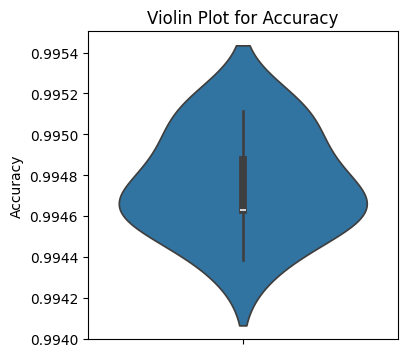

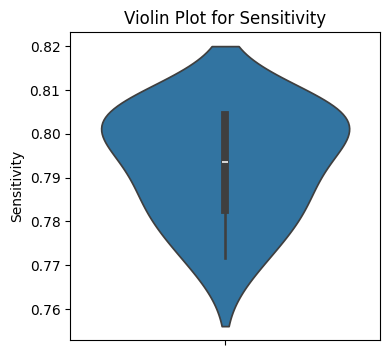

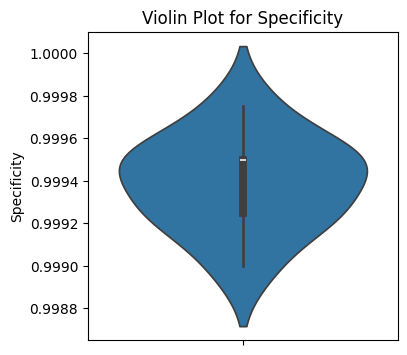

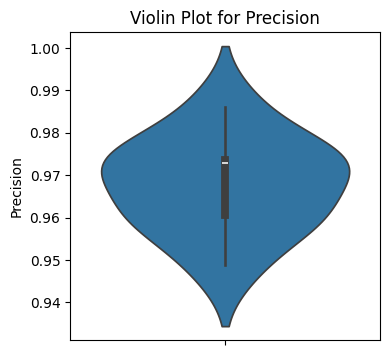

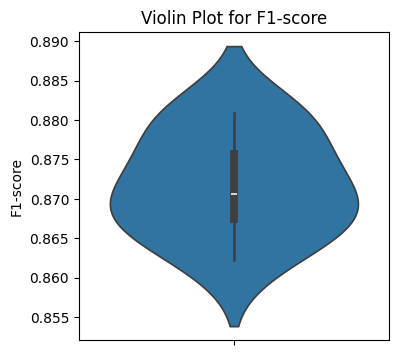

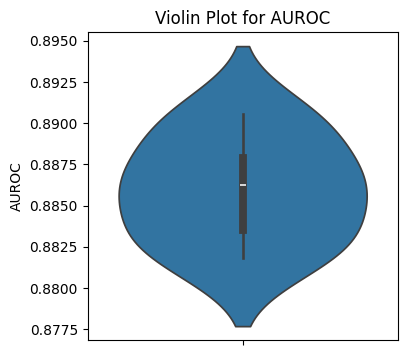

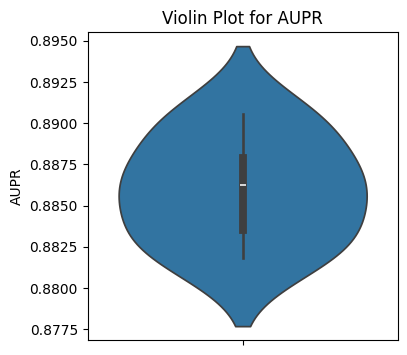

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

#******************  Data spliting and manipulation *******************

X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.2, random_state=73)  ### will comment out in 2nd dataset
# X_train=Features[Features.index <= 32560]    #######--> for 2nd dataset only.. will comment out for others
# X_test=Features[Features.index > 32560]      #######--> for 2nd dataset only.. will comment out for others
# X_train=X_train.reset_index(drop=True)      #######--> for 2nd dataset only.. will comment out for others
# X_test=X_test.reset_index(drop=True)        #######--> for 2nd dataset only.. will comment out for others


X_train,X_validation,y_train,y_validation= train_test_split(X_train, y_train, test_size=0.2, random_state=73)
X_train=X_train.to_numpy(dtype=float)
y_train=y_train.to_numpy().T[0]
X_validation=X_validation.to_numpy(dtype=float)
y_validation=y_validation.to_numpy().T[0]
X_test=X_test.to_numpy(dtype=float)
y_test=y_test.to_numpy().T[0]


#******************** logistic regression *********************

params={
        'n':X_train.shape[1],
        'b':1,
        'alpha':0.009,
        'epoch':10000,
        'lemda':0.001
        }
LogisticRegressionModel=LogisticRegression(params)
LogisticRegressionModel.fit(X_train,y_train)
y_pred=LogisticRegressionModel.predict(X_test)
metrics=metric()
metrics.count(y_test, y_pred)
accuracy = metrics.accuracy()
sensitivity=metrics.sensitivity()
specificity=metrics.specificity()
precision=metrics.precesion()
F1score=metrics.F1Score()
Auroc=roc_auc_score(y_test,LogisticRegressionModel.y_prob(X_test))
AuPR=average_precision_score(y_test,LogisticRegressionModel.y_prob(X_test))

print("Performance on Test set:\n")
print("Logistic Regression:")
print(f"accuracy: {accuracy:.6f} sensitivity: {sensitivity:.6f} specificity: {specificity:.6f} precision: {precision:.6f} F1score: {F1score:.6f} Auroc: {Auroc:.6f} AUPR:{AuPR:.6f}\n")

#*************   ensemble    ****************

####### voting ##############

Votingmodel=Bagging()
Votingmodel.fit(X_train,y_train)
y_pred2=Votingmodel.predict(X_test)
metrics2=metric()
metrics2.count(y_test, y_pred2)
accuracy2 = metrics2.accuracy()
sensitivity2=metrics2.sensitivity()
specificity2=metrics2.specificity()
precision2=metrics2.precesion()
F1score2=metrics2.F1Score()
Auroc2=roc_auc_score(y_test,Votingmodel.y_prob(X_test))
AuPR2=average_precision_score(y_test,Votingmodel.y_prob(X_test))

print("Voting ensemble:")
print(f"accuracy: {accuracy2:.6f} sensitivity: {sensitivity2:.6f} specificity: {specificity2:.6f} precision: {precision2:.6f} F1score: {F1score2:.6f} Auroc: {Auroc2:.6f} AUPR:{AuPR2:.6f}\n")


########## stacking ##############


Stackingmodel=stacking()
Stackingmodel.fit(X_train,y_train,X_validation,y_validation)
y_pred3 =Stackingmodel.predict(X_test)
metrics3=metric()
metrics3.count(y_test, y_pred3)
accuracy3 = metrics3.accuracy()
sensitivity3=metrics3.sensitivity()
specificity3=metrics3.specificity()
precision3=metrics3.precesion()
F1score3=metrics3.F1Score()
Auroc3=roc_auc_score(y_test,Stackingmodel.y_prob(X_test))
AuPR3=average_precision_score(y_test,Stackingmodel.y_prob(X_test))

print("Stacking ensemble:")
print(f"accuracy: {accuracy3:.6f} sensitivity: {sensitivity3:.6f} specificity: {specificity3:.6f} precision: {precision3:.6f} F1score: {F1score3:.6f} Auroc: {Auroc3:.6f} AUPR:{AuPR3:.6f}\n")



########################   violin plots     ############################

import seaborn as sns
import matplotlib.pyplot as plt

models=Votingmodel.Models
accuracyof9 = []
sensitivityof9=[]
specificityof9=[]
precisionof9=[]
F1scoreof9=[]
Aurocof9=[]
AuPRof9=[]
for model in models:
    metricsof9=metric()
    metricsof9.count(y_test,model.predict(X_test))
    accuracyof9.append(metricsof9.accuracy())
    sensitivityof9.append(metricsof9.sensitivity())
    specificityof9.append(metricsof9.specificity())
    precisionof9.append(metricsof9.precesion())
    F1scoreof9.append(metricsof9.F1Score())
    Aurocof9.append(roc_auc_score(y_test,model.y_prob(X_test)))
    AuPRof9.append(average_precision_score(y_test,model.y_prob(X_test)))

data = {
    'Accuracy': accuracyof9,
    'Sensitivity': sensitivityof9,
    'Specificity': specificityof9 ,
    'Precision': precisionof9,
    'F1-score': F1scoreof9,
    'AUROC': AuPRof9,
    'AUPR': AuPRof9
}


df = pd.DataFrame(data)
mean_std = df.agg(['mean', 'std'])
print(" Average and Stdev for the 9 bagging LR learners:")
print(mean_std)



# Draw a violin plot for each performance metric
for column in df.columns:
    plt.figure(figsize=(4, 4))
    sns.violinplot(data=df[column], inner="box")
    plt.title(f'Violin Plot for {column}')
    plt.show()




